# Библиотеки

In [ ]:
%%capture
!pip install corus pandas nltk pymorphy3 scikit-learn nltk

In [ ]:
from corus import load_lenta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymorphy3
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import functools
from itertools import chain
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Получение репрезентативной части датасета

**Размер:** 100000 текстов в датафрейме

In [ ]:
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

In [ ]:
path = 'lenta-ru-news.csv.gz'
records = load_lenta(path)

In [ ]:
data = []
for record in records:
    data.append({
        'title': record.title,
        'text': record.text,
        'topic': record.topic
    })

df = pd.DataFrame(data)

In [ ]:
df.head()

,title,text,topic
0,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия
1,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт
2,Обнаружено самое счастливое место на планете,Сотрудники социальной сети Instagram проанализ...,Путешествия
3,В США раскрыли сумму расходов на расследование...,С начала расследования российского вмешательст...,Мир
4,Хакеры рассказали о планах Великобритании зами...,Хакерская группировка Anonymous опубликовала н...,Мир


In [ ]:
df.shape

(739351, 3)

<ipython-input-8-1be13f182f84>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.values, y=topic_counts.index, palette="viridis")


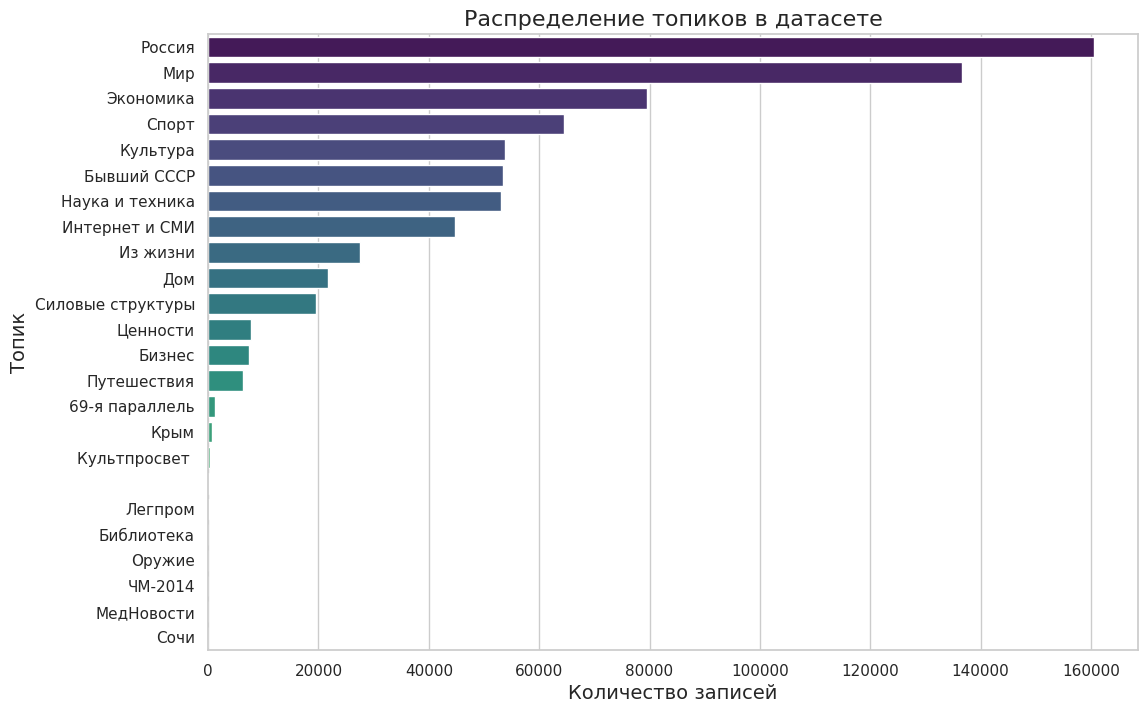

In [ ]:
sns.set(style="whitegrid")
topic_counts = df['topic'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=topic_counts.values, y=topic_counts.index, palette="viridis")
plt.title('Распределение топиков в датасете', fontsize=16)
plt.xlabel('Количество записей', fontsize=14)
plt.ylabel('Топик', fontsize=14)
plt.show()

In [ ]:
topic_counts

,count
topic,
Россия,160519
Мир,136680
Экономика,79538
Спорт,64421
Культура,53803
Бывший СССР,53402
Наука и техника,53136
Интернет и СМИ,44675
Из жизни,27611


> Функция `find_optimal_base_class` определяет базовый класс, чтобы вошло максимальное кол-во топиков в датасет при ограничении в 100 тыс. текстов.



In [ ]:
def find_optimal_base_class(topic_counts, max_samples=100000):
    best = {}
    sorted_topics = topic_counts.sort_values(ascending=False)

    for topic, count in sorted_topics.items():
        eligible = sorted_topics[sorted_topics >= count]
        base_size = len(eligible) * count

        if base_size > max_samples:
            continue

        remaining = max_samples - base_size
        extra_per_class = remaining // len(eligible) if len(eligible) > 0 else 0
        extra_total = sum((eligible - count).clip(upper=extra_per_class))
        total = base_size + extra_total

        score = len(eligible) * 1000 + total

        if score > best.get('score', 0):
            best = {
                'base_class': topic,
                'base_count': count,
                'num_classes': len(eligible),
                'total_samples': total,
                'score': score
            }

    return best

In [ ]:
topic_counts = df['topic'].value_counts()
best = find_optimal_base_class(topic_counts)

print(f'''Оптимальный базовый класс: {best['base_class']}
Количество текстов: {best['base_count']}
Включено классов: {best['num_classes']}
Общий размер датасета: {best['total_samples']}''')

Оптимальный базовый класс: Путешествия
Количество текстов: 6408
Включено классов: 14
Общий размер датасета: 99254


Балансируем классы до базового уровня (6408 для "Путешествий")

In [ ]:
df_filtered = df[df['topic'].isin(topic_counts[topic_counts >= best['base_count']].index)]
df_balanced = df_filtered.groupby('topic').head(best['base_count']).reset_index(drop=True)

remaining_samples = 100000 - len(df_balanced)
topics = df_balanced['topic'].unique().tolist()
topics.remove(best['base_class'])
num_classes = len(topics)

samples_per_class, extra_samples = divmod(remaining_samples, num_classes)

Добавляем дополнительные данные к каждому классу, кроме базового

In [ ]:
additional = []
for i, topic in enumerate(topics):
    needed = samples_per_class + (i < extra_samples)
    topic_data = df_filtered[df_filtered['topic'] == topic].iloc[best['base_count'] : best['base_count']+needed]
    additional.append(topic_data)

df_final = pd.concat([df_balanced] + additional, ignore_index=True)

print("\nИтоговое распределение:")
print(df_final['topic'].value_counts())
print(f"Общее количество строк: {len(df_final)}")


Итоговое распределение:
topic
Россия               7200
Спорт                7200
Мир                  7200
Бывший СССР          7200
Интернет и СМИ       7200
Силовые структуры    7199
Экономика            7199
Культура             7199
Дом                  7199
Наука и техника      7199
Из жизни             7199
Ценности             7199
Бизнес               7199
Путешествия          6408
Name: count, dtype: int64
Общее количество строк: 100000


<ipython-input-14-714696da1227>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.values, y=topic_counts.index, palette="viridis")


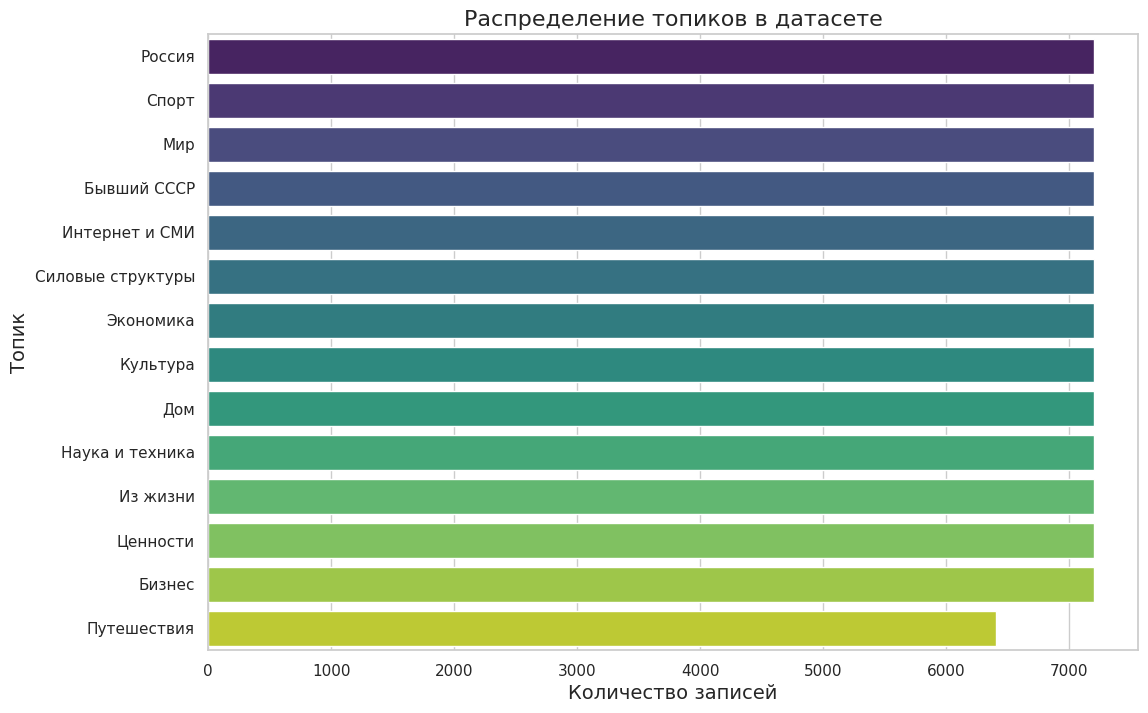

In [ ]:
sns.set(style="whitegrid")
topic_counts = df_final['topic'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=topic_counts.values, y=topic_counts.index, palette="viridis")
plt.title('Распределение топиков в датасете', fontsize=16)
plt.xlabel('Количество записей', fontsize=14)
plt.ylabel('Топик', fontsize=14)
plt.show()

# Предобработка данных

Заголовок часто содержит ключевые слова темы, поэтому предлагаю объединить заголовки с текстами

In [ ]:
df_final['combined_text'] = df_final['title'] + ' ' + df_final['text']
df_final.head()

,title,text,topic,combined_text
0,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия,Названы регионы России с самой высокой смертно...
1,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт,Австрия не представила доказательств вины росс...
2,Обнаружено самое счастливое место на планете,Сотрудники социальной сети Instagram проанализ...,Путешествия,Обнаружено самое счастливое место на планете С...
3,В США раскрыли сумму расходов на расследование...,С начала расследования российского вмешательст...,Мир,В США раскрыли сумму расходов на расследование...
4,Хакеры рассказали о планах Великобритании зами...,Хакерская группировка Anonymous опубликовала н...,Мир,Хакеры рассказали о планах Великобритании зами...


Для предобработки данных предлагаю реализовать сдедующую нормализацию текста, включающую:

1. Приведение к нижнему регистру для устранения вариативности написания слов;

2. Удаление цифр, специальных символов и знаков пунктуации с помощью регулярных выражений;

3. Лемматизацию с использованием `pymorphy3` (вместо стемминга);
> Лемматизация, в отличие от стемминга, сохраняет семантику и грамматическую корректность, что повышает интерпретируемость признаков.

4. Фильтрацию стоп-слов на основе стандартного списка `nltk` для исключения неинформативных токенов.

In [ ]:
morph = pymorphy3.MorphAnalyzer()
STOP_WORDS = set(stopwords.words('russian'))

In [ ]:
@functools.lru_cache(maxsize=10000)
def get_normal_form(word):
    return morph.parse(word)[0].normal_form

def preprocess(text, debug=False):
    original = text

    lower_text = text.lower()

    cleaned_text = re.sub(r'[^\w\s]|[\d_]', '', lower_text)

    tokens = []
    debug_normalized = []
    for word in cleaned_text.split():
        normalized = get_normal_form(word)
        if normalized and normalized not in STOP_WORDS:
            tokens.append(normalized)
            debug_normalized.append(normalized)

    if debug:
        print(f"Исходный текст:\n{original}\n")
        print(f"Приведение к нижнему регистру:\n{lower_text}\n")
        print(f"Очистка от спецсимволов и цифр:\n{cleaned_text}\n")
        print(f"Нормализация:\n {' '.join(debug_normalized)}")
        print("="*50)

    return ' '.join(tokens)

Обработаем какой-нибудь текст и выведем результат

In [ ]:
preprocess(df_final['combined_text'][3], debug=True)

Исходный текст:
В США раскрыли сумму расходов на расследование «российского дела» С начала расследования российского вмешательства в выборы власти США потратили более 25 миллионов долларов. Об этом сообщает Associated Press со ссылкой на отчет Министерства юстиции США. В документе содержатся данные о расходах на следствие с апреля по сентябрь 2018 года. За эти полгода было потрачено 4,6 миллиона долларов, из которых почти 3 миллиона долларов ушли на зарплату сотрудников, 580 тысяч — на поездки и сопутствующие расходы. Ранее Минюст США уже публиковал отчеты о затратах на дело о российском вмешательстве за предыдущие месяцы. 11 декабря расследование спецпрокурора Робера Мюллера показало, что по меньшей мере 14 человек из окружения президента США Дональда Трампа контактировали с россиянами во время его избирательной кампании и последующего переходного периода перед вступлением в должность главы государства. Мюллер с 2017 года ведет дело о якобы российском вмешательстве в американские выбо

'сша раскрыть сумма расход расследование российский дело начало расследование российский вмешательство выборы власть сша потратить миллион доллар это сообщать associated press ссылка отчёт министерство юстиция сша документ содержаться дать расход следствие апрель сентябрь год полгода потратить миллион доллар который миллион доллар уйти зарплата сотрудник тысяча поездка сопутствовать расход ранее минюст сша публиковать отчёт затрата дело российский вмешательство предыдущий месяц декабрь расследование спецпрокурор робер мюллер показать малый мера человек окружение президент сша дональд трамп контактировать россиянин время избирательный кампания последующий переходный период вступление должность глава государство мюллер год вести дело якобы российский вмешательство американский выборы м поставить задача выяснить сговор штаб трамп россия кремль белый дом отвергать всё обвинение россия неоднократно обвинять вмешательство выборы президент сша помощь хакер июнь спецслужба выдвинуть заочный об

Примененим ко всему датафрейму

In [ ]:
df_final['clean_text'] = df_final['combined_text'].apply(preprocess)
df_final.head()

,title,text,topic,combined_text,clean_text
0,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия,Названы регионы России с самой высокой смертно...,назвать регион россия высокий смертность рак в...
1,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт,Австрия не представила доказательств вины росс...,австрия представить доказательство вина россий...
2,Обнаружено самое счастливое место на планете,Сотрудники социальной сети Instagram проанализ...,Путешествия,Обнаружено самое счастливое место на планете С...,обнаружить самый счастливый место планета сотр...
3,В США раскрыли сумму расходов на расследование...,С начала расследования российского вмешательст...,Мир,В США раскрыли сумму расходов на расследование...,сша раскрыть сумма расход расследование россий...
4,Хакеры рассказали о планах Великобритании зами...,Хакерская группировка Anonymous опубликовала н...,Мир,Хакеры рассказали о планах Великобритании зами...,хакер рассказать план великобритания заминиров...


Резделим датафрейм на обучающую, валидационную и тестовую выборки (60/20/20)

In [ ]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    df_final['clean_text'], df_final['topic'],
    test_size=0.4, stratify=df_final['topic'], random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test,
    test_size=0.5, stratify=y_val_test, random_state=42
)

# DummyClassifier

Для установки базового уровня качества классификации был выбран **DummyClassifier** со стратегией `"stratified"`, так как он предсказывает метки, сохраняя распределение классов из обучающей выборки.

In [ ]:
dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy.fit(X_train, y_train)
y_test_pred_dummy = dummy.predict(X_test)
print("DummyClassifier Classification Report (test):\n", classification_report(y_test, y_test_pred_dummy))

DummyClassifier Classification Report (test):
                    precision    recall  f1-score   support

           Бизнес       0.07      0.07      0.07      1439
      Бывший СССР       0.07      0.07      0.07      1440
              Дом       0.06      0.07      0.06      1439
         Из жизни       0.07      0.07      0.07      1440
   Интернет и СМИ       0.09      0.09      0.09      1440
         Культура       0.07      0.07      0.07      1440
              Мир       0.07      0.07      0.07      1440
  Наука и техника       0.07      0.07      0.07      1440
      Путешествия       0.07      0.07      0.07      1282
           Россия       0.08      0.08      0.08      1440
Силовые структуры       0.07      0.07      0.07      1440
            Спорт       0.07      0.07      0.07      1440
         Ценности       0.07      0.07      0.07      1440
        Экономика       0.08      0.08      0.08      1440

         accuracy                           0.07     20000
       

Результат показывает, что метрики `precision, recall, F1` для всех классов около **7%**, что близко к случайному угадыванию. Это значит, что настоящие модели должны быть значительно лучше — такой результат задаёт нижнюю границу качества, которую нужно преодолеть.
Точность 7% также подтверждает, что классы примерно сбалансированы (нет доминирующего класса), что упрощает обучение моделей.

# LogisticRegression

## CountVectorizer

In [ ]:
pipe_count = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

In [ ]:
pipe_count.fit(X_train, y_train)
y_val_pred_count = pipe_count.predict(X_val)

In [ ]:
print("CountVectorizer Validation Classification Report:\n", classification_report(y_val, y_val_pred_count, digits=4))

CountVectorizer Validation Classification Report:
                    precision    recall  f1-score   support

           Бизнес     0.7882    0.8063    0.7971      1440
      Бывший СССР     0.8962    0.8931    0.8946      1440
              Дом     0.8965    0.8722    0.8842      1440
         Из жизни     0.7928    0.8264    0.8092      1440
   Интернет и СМИ     0.8536    0.8257    0.8394      1440
         Культура     0.8977    0.9076    0.9026      1440
              Мир     0.8004    0.8299    0.8149      1440
  Наука и техника     0.8880    0.8979    0.8930      1440
      Путешествия     0.8962    0.8767    0.8863      1281
           Россия     0.7384    0.7410    0.7397      1440
Силовые структуры     0.8272    0.8214    0.8243      1439
            Спорт     0.9636    0.9736    0.9686      1440
         Ценности     0.9377    0.9299    0.9338      1440
        Экономика     0.7873    0.7556    0.7711      1440

         accuracy                         0.8539     20000
   

## TfidfVectorizer

In [ ]:
pipe_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

In [ ]:
pipe_tfidf.fit(X_train, y_train)
y_val_pred_tfidf = pipe_tfidf.predict(X_val)

In [ ]:
print("TfidfVectorizer Validation Classification Report:\n", classification_report(y_val, y_val_pred_tfidf, digits=4))

TfidfVectorizer Validation Classification Report:
                    precision    recall  f1-score   support

           Бизнес     0.7707    0.8194    0.7943      1440
      Бывший СССР     0.8916    0.9028    0.8972      1440
              Дом     0.8959    0.8549    0.8749      1440
         Из жизни     0.7908    0.8403    0.8148      1440
   Интернет и СМИ     0.8424    0.8243    0.8333      1440
         Культура     0.8775    0.9000    0.8886      1440
              Мир     0.8038    0.8222    0.8129      1440
  Наука и техника     0.8812    0.9118    0.8962      1440
      Путешествия     0.8904    0.8876    0.8890      1281
           Россия     0.7551    0.7257    0.7401      1440
Силовые структуры     0.8179    0.8179    0.8179      1439
            Спорт     0.9581    0.9694    0.9638      1440
         Ценности     0.9444    0.9194    0.9317      1440
        Экономика     0.8114    0.7319    0.7696      1440

         accuracy                         0.8517     20000
   

# Оптимизация гиперпараметров

In [ ]:
params = {
    'vectorizer__max_df': [0.7 ,0.8, 0.9, 1],
    'vectorizer__max_features': [25_000, 30_000, 35_000],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'model__C': [0.1, 1, 10]
}

Ниже приведено пояснение, почему я выбрал такие варианты значений для `'vectorizer__max_features'`

Собираем все токены из тренировочных текстов в один список, считаем частоту токенов и берем N самых частых

In [ ]:
MAX_FEATURES1 = 25_000
MAX_FEATURES2 = 30_000
MAX_FEATURES3 = 35_000

all_tokens = list(chain.from_iterable(text.split() for text in X_train))

def min_common_token_count(all_tokens, MAX_FEATURES):
  common_tokens = Counter(all_tokens).most_common(MAX_FEATURES)
  min_count = common_tokens[-1][1] if common_tokens else 0
  return min_count

print(f'Минимальная частота среди {MAX_FEATURES1} популярных токенов: {min_common_token_count(all_tokens, MAX_FEATURES1)}')
print(f'Минимальная частота среди {MAX_FEATURES2} популярных токенов: {min_common_token_count(all_tokens, MAX_FEATURES2)}')
print(f'Минимальная частота среди {MAX_FEATURES3} популярных токенов: {min_common_token_count(all_tokens, MAX_FEATURES3)}')

Минимальная частота среди 25000 популярных токенов: 16
Минимальная частота среди 30000 популярных токенов: 11
Минимальная частота среди 35000 популярных токенов: 8


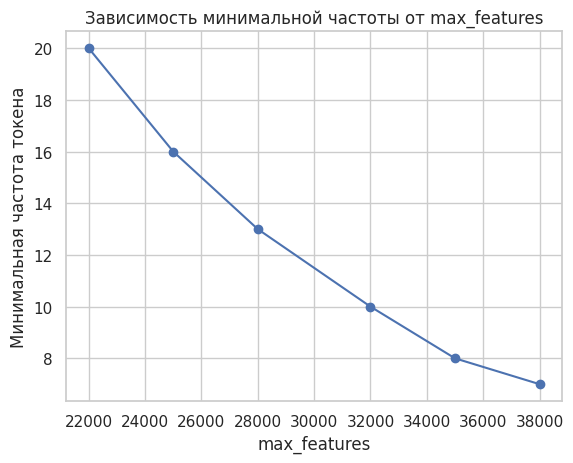

In [ ]:
x = [22_000, 25_000, 28_000, 32_000, 35_000, 38_000]
y = [min_common_token_count(all_tokens, k) for k in x]

plt.plot(x, y, marker='o')
plt.xlabel('max_features')
plt.ylabel('Минимальная частота токена')
plt.title('Зависимость минимальной частоты от max_features')
plt.show()

## CountVectorizer + RandomizedSearchCV

In [ ]:
random_count = RandomizedSearchCV(
    pipe_count,
    params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
random_count.fit(X_train, y_train)
best_params_count = random_count.best_params_
best_params_count

{'vectorizer__ngram_range': (1, 2),
 'vectorizer__max_features': 35000,
 'vectorizer__max_df': 0.9,
 'model__C': 0.1}

In [ ]:
best_pipe_count = Pipeline([
    ('vectorizer', CountVectorizer(
        max_features=best_params_count['vectorizer__max_features'],
        ngram_range=best_params_count['vectorizer__ngram_range'],
        max_df=best_params_count['vectorizer__max_df']
    )),
    ('model', LogisticRegression(
        C=best_params_count['model__C'],
        random_state=42,
        max_iter=1000
    ))
])

In [ ]:
best_pipe_count.fit(X_train, y_train)
y_val_pred_count_random = best_pipe_count.predict(X_val)

In [ ]:
print("CountVectorizer + RandomizedSearchCV Validation Classification Report:\n", classification_report(y_val, y_val_pred_count_random, digits=4))

CountVectorizer + RandomizedSearchCV Validation Classification Report:
                    precision    recall  f1-score   support

           Бизнес     0.8080    0.8097    0.8089      1440
      Бывший СССР     0.9055    0.8986    0.9021      1440
              Дом     0.9074    0.8910    0.8991      1440
         Из жизни     0.8082    0.8396    0.8236      1440
   Интернет и СМИ     0.8604    0.8389    0.8495      1440
         Культура     0.8968    0.9111    0.9039      1440
              Мир     0.8123    0.8444    0.8281      1440
  Наука и техника     0.8953    0.9090    0.9021      1440
      Путешествия     0.9141    0.8884    0.9010      1281
           Россия     0.7599    0.7583    0.7591      1440
Силовые структуры     0.8449    0.8443    0.8446      1439
            Спорт     0.9610    0.9750    0.9679      1440
         Ценности     0.9398    0.9319    0.9358      1440
        Экономика     0.8026    0.7708    0.7864      1440

         accuracy                        

## TfidfVectorizer + RandomizedSearchCV

In [ ]:
random_tfidf = RandomizedSearchCV(
    pipe_tfidf,
    params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
random_tfidf.fit(X_train, y_train)
best_params_tfidf = random_tfidf.best_params_
best_params_tfidf

{'vectorizer__ngram_range': (1, 1),
 'vectorizer__max_features': 30000,
 'vectorizer__max_df': 0.7,
 'model__C': 10}

In [ ]:
best_pipe_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(
        max_features=best_params_tfidf['vectorizer__max_features'],
        ngram_range=best_params_tfidf['vectorizer__ngram_range'],
        max_df=best_params_tfidf['vectorizer__max_df']
    )),
    ('model', LogisticRegression(
        C=best_params_tfidf['model__C'],
        random_state=42,
        max_iter=1000
    ))
])

In [ ]:
best_pipe_tfidf.fit(X_train, y_train)
y_val_pred_tfidf_random = best_pipe_tfidf.predict(X_val)

In [ ]:
print("TfidfVectorizer + RandomizedSearchCV Validation Classification Report:\n", classification_report(y_val, y_val_pred_tfidf_random, digits=4))

TfidfVectorizer + RandomizedSearchCV Validation Classification Report:
                    precision    recall  f1-score   support

           Бизнес     0.7835    0.8167    0.7997      1440
      Бывший СССР     0.9003    0.9097    0.9050      1440
              Дом     0.9045    0.8812    0.8927      1440
         Из жизни     0.7959    0.8368    0.8158      1440
   Интернет и СМИ     0.8603    0.8340    0.8470      1440
         Культура     0.8949    0.9167    0.9057      1440
              Мир     0.8165    0.8340    0.8251      1440
  Наука и техника     0.8855    0.9076    0.8964      1440
      Путешествия     0.9103    0.8868    0.8984      1281
           Россия     0.7708    0.7521    0.7613      1440
Силовые структуры     0.8386    0.8339    0.8362      1439
            Спорт     0.9623    0.9743    0.9683      1440
         Ценности     0.9403    0.9292    0.9347      1440
        Экономика     0.8073    0.7535    0.7795      1440

         accuracy                        

# Оценка качества лучшего пайплайна на тестовой выборке

## CountVectorizer + RandomizedSearchCV (test)

In [ ]:
y_test_pred_count_random = best_pipe_count.predict(X_test)

In [ ]:
print("CountVectorizer + RandomizedSearchCV Classification Report (test):\n", classification_report(y_test, y_test_pred_count_random, digits=4))

CountVectorizer + RandomizedSearchCV Classification Report (test):
                    precision    recall  f1-score   support

           Бизнес     0.8203    0.8214    0.8208      1439
      Бывший СССР     0.9024    0.9118    0.9071      1440
              Дом     0.9065    0.8958    0.9011      1439
         Из жизни     0.8125    0.8396    0.8258      1440
   Интернет и СМИ     0.8684    0.8389    0.8534      1440
         Культура     0.9088    0.9278    0.9182      1440
              Мир     0.8282    0.8438    0.8359      1440
  Наука и техника     0.8962    0.9056    0.9009      1440
      Путешествия     0.8899    0.8830    0.8865      1282
           Россия     0.7664    0.7861    0.7761      1440
Силовые структуры     0.8456    0.8368    0.8412      1440
            Спорт     0.9603    0.9750    0.9676      1440
         Ценности     0.9484    0.9194    0.9337      1440
        Экономика     0.8187    0.7840    0.8010      1440

         accuracy                         0.8

## TfidfVectorizer + RandomizedSearchCV (test)

In [ ]:
y_test_pred_tfidf_random = best_pipe_tfidf.predict(X_test)

In [ ]:
print("TfidfVectorizer + RandomizedSearchCV Classification Report (test):\n", classification_report(y_test, y_test_pred_tfidf_random, digits=4))

TfidfVectorizer + RandomizedSearchCV Classification Report (test):
                    precision    recall  f1-score   support

           Бизнес     0.7887    0.8145    0.8014      1439
      Бывший СССР     0.9002    0.9083    0.9043      1440
              Дом     0.8988    0.8951    0.8969      1439
         Из жизни     0.8030    0.8264    0.8145      1440
   Интернет и СМИ     0.8563    0.8278    0.8418      1440
         Культура     0.9119    0.9278    0.9198      1440
              Мир     0.8165    0.8500    0.8329      1440
  Наука и техника     0.8947    0.9090    0.9018      1440
      Путешествия     0.8928    0.8838    0.8883      1282
           Россия     0.7632    0.7701    0.7667      1440
Силовые структуры     0.8312    0.8243    0.8278      1440
            Спорт     0.9582    0.9722    0.9652      1440
         Ценности     0.9490    0.9181    0.9333      1440
        Экономика     0.8254    0.7583    0.7904      1440

         accuracy                         0.8

# Вывод

Обе модели на основе CountVectorizer и TfidfVectorizer продемонстрировали сопоставимое качество (accuracy ~86-87%), что указывает на схожую эффективность методов векторизации для данной задачи. Это может быть связано с особенностями корпуса, где частотные признаки (учитываемые CountVectorizer) оказались столь же информативны, как и взвешенные по TF-IDF.

Балансировка данных позволила:
- Включить 14 классов из исходного корпуса, сохранив репрезентативность выборки при ограничении в 100 тыс. текстов;
- Равномерно распределить примеры между классами (по ~7200 на класс), кроме базового ("Путешествия" — 6408), минимизировав дисбаланс.

Обе модели (CountVectorizer и TfidfVectorizer) значительно превзошли DummyClassifier, который показал accuracy 7% и F1-меру в диапазоне 0.06–0.09 для всех классов.